# Projet Bayes 2 - Hearts

## Importation des données

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
path = "data.csv"

In [3]:
data = pd.read_csv(path)
data

,Unnamed: 0,t,x,y
0,1,11,6,5
1,2,11,9,2
2,3,17,17,0
3,4,22,22,0
4,5,9,7,2
5,6,6,5,1
6,7,5,5,0
7,8,14,14,0
8,9,9,9,0
9,10,7,7,0


## Échantilloneur

In [4]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [5]:
init = [0,0]

In [6]:
def MH (data,init,n,prop_sd,sigma = 1e2) :
    # X = [alpha, beta, delta, theta]
    X = np.zeros((n+1,4), dtype=np.float32)
    X[0] = [init[0],
            np.exp(init[0]),
            init[1],
            sigmoid(init[1])]
    id0 = (data["y"] == 0)
    id_sup = ~id0
    
    # Calcul des probas d'acceptation
    P = [0,0]
    
    for i in range(1,n+1) :
        # Calcul de alpha
        alpha = X[i-1,0]
        theta = X[i-1,3]
        prop_alpha = np.random.normal(alpha,prop_sd[0])
        
        def log_pdf_alpha(x) :
            p = sigmoid(x)
            
            s = -(x**2)/(2*sigma**2) + \
            np.sum(np.log(theta + (1-theta)*(1-p)**data[id0]["t"])) + \
            np.sum(data[id_sup]["y"]*np.log(p) + (data[id_sup]["t"] - data[id_sup]["y"])*np.log(1-p))
            
            return s
        
        top = log_pdf_alpha(prop_alpha)
        bottom = log_pdf_alpha(alpha)
        acc = np.exp(top - bottom)
        
        if np.random.uniform() < acc :
            X[i,0] = prop_alpha
            P[0] +=1
        else : 
            X[i,0] = alpha
        
        # Calcul de delta
        delta = X[i-1,2]
        p = sigmoid(X[i,0])
        prop_delta = np.random.normal(delta,prop_sd[1])
        
        def log_pdf_delta(x) :
            theta = sigmoid(x)
            
            s = -(x**2)/(2*sigma**2) + \
            np.sum(np.log(theta + (1-theta)*(1-p)**data[id0]["t"])) + \
            np.log(1-theta)*np.sum(id_sup)
            
            return s
        
        top = log_pdf_delta(prop_delta)
        bottom = log_pdf_delta(delta)

        acc = np.exp(top - bottom)
        
        if np.random.uniform() < acc :
            X[i,2] = prop_delta
            P[1] += 1
        else : 
            X[i,2] = delta
            
        # Calcul de beta et theta
        X[i,1] = np.exp(X[i,0])
        X[i,3] = sigmoid(X[i,2])
        
    return (X,np.array(P)/n)

In [7]:
X,P = MH(data,init,10000,[0.05,1])

## Analyse des résultats

In [8]:
X_burn = X[1000:]
alpha = X_burn[:,0]
beta = X_burn[:,1]
delta = X_burn[:,2]
theta = X_burn[:,3]

Text(0.5, 1.0, 'Theta')

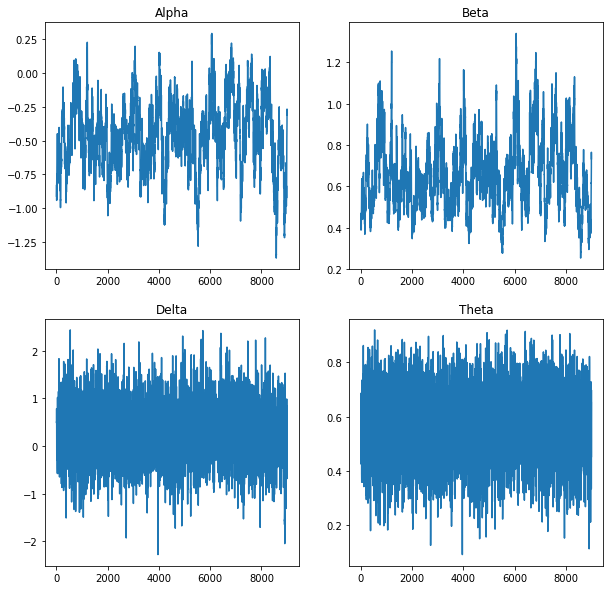

In [9]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))

# alpha
ax[0,0].plot(alpha)
ax[0,0].set_title("Alpha")

# beta
ax[0,1].plot(beta)
ax[0,1].set_title("Beta")

# delta
ax[1,0].plot(delta)
ax[1,0].set_title("Delta")

# theta
ax[1,1].plot(theta)
ax[1,1].set_title("Theta")

In [10]:
P

array([0.9434, 0.5728])

In [11]:
coef = {'alpha': alpha,
       'beta': beta,
       'delta': delta,
       'theta': theta}
coef = pd.DataFrame(coef)
coef.describe(percentiles=[0.025,0.975])

,alpha,beta,delta,theta
count,9001.000000,9001.000000,9001.000000,9001.000000
mean,-0.457498,0.654220,0.292613,0.566757
std,0.258600,0.169784,0.623994,0.141027
min,-1.369842,0.254147,-2.279330,0.092849
2.5%,-0.982563,0.374351,-0.882364,0.292688
50%,-0.458911,0.631972,0.296920,0.573690
97.5%,0.027647,1.028032,1.528998,0.821860
max,0.292419,1.339665,2.437030,0.919608


In [13]:
print(coef.describe(percentiles=[0.025,0.975]).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &        alpha &         beta &        delta &        theta \\
\midrule
count &  9001.000000 &  9001.000000 &  9001.000000 &  9001.000000 \\
mean  &    -0.457498 &     0.654220 &     0.292613 &     0.566757 \\
std   &     0.258600 &     0.169784 &     0.623994 &     0.141027 \\
min   &    -1.369842 &     0.254147 &    -2.279330 &     0.092849 \\
2.5\%  &    -0.982563 &     0.374351 &    -0.882364 &     0.292688 \\
50\%   &    -0.458911 &     0.631972 &     0.296920 &     0.573690 \\
97.5\% &     0.027647 &     1.028032 &     1.528998 &     0.821860 \\
max   &     0.292419 &     1.339665 &     2.437030 &     0.919608 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_10905/2179905425.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(coef.describe(percentiles=[0.025,0.975]).to_latex())
